In [547]:
import os
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
import matplotlib.cm as cm
from matplotlib.lines import Line2D

In [61]:

def generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences):
    sequences = []
    for _ in range(num_sequences):
        seq, conditions = [], []
        match_positions = random.sample(range(n, seq_length), matches)
        match_positions.sort()

        for i in range(seq_length):
            if i in match_positions:
                seq.append(seq[i - n])
                conditions.append('m')
            else:
                random_letter = random.choice(alphabet)
                while i > n and seq[i - n] == random_letter:
                    random_letter = random.choice(alphabet)
                seq.append(random_letter)
                conditions.append('-')

        sequences.append((''.join(seq), ''.join(conditions)))

    return sequences

def save_sequences_to_json(sequences, output_file):
    data = []
    for seq, conditions in sequences:
        data.append({
            "input": seq,
            "target": conditions
        })
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)


In [62]:

alphabet = 'bcdfghjklnpqrstvwxyz'
seq_length = 24
matches = 8
num_sequences_train = 800
num_sequences_test = 200


In [63]:
# for n in [1, 2, 3, 4, 5, 6]:
#     sequences_train = generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences_train)
#     sequences_test = generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences_test)

#     save_sequences_to_json(sequences_train, f'nback_{n}_train.json')
#     save_sequences_to_json(sequences_test, f'nback_{n}_test.json')


In [64]:
# Define the dataset
class NBackDataset(Dataset):
    def __init__(self, json_file, char_to_idx, label_to_idx):
        self.data = []
        with open(json_file, 'r') as f:
            data_json = json.load(f)
            for item in data_json:
                input_seq = [char_to_idx[char] for char in item['input']]
                target_seq = [label_to_idx[label] for label in item['target']]
                self.data.append((torch.tensor(input_seq), torch.tensor(target_seq)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [65]:
class SimpleDecoderLayer(nn.Module):
    def __init__(self, model_dim, num_heads):
        super(SimpleDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=model_dim, num_heads=num_heads)

    def forward(self, x, mask):
        attn_output, attention_weights = self.self_attn(x, x, x, attn_mask=mask, average_attn_weights=False)
        return attn_output, attention_weights

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, max_seq_len):
        super(DecoderOnlyTransformer, self).__init__()
        self.embedding = nn.Embedding(input_dim, model_dim)
        self.positional_encoding = nn.Embedding(max_seq_len, model_dim)

        self.layers = nn.ModuleList([SimpleDecoderLayer(model_dim, num_heads) for _ in range(num_layers)])
        self.unembed = nn.Linear(model_dim, output_dim)

    def forward(self, x, mask, output_attentions=False, output_positions=False):
        seq_len = x.size(1)
        x = x.transpose(0, 1)
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)
        positions = positions.transpose(0, 1)

        x = self.embedding(x) + self.positional_encoding(positions)

        embedded_x = self.positional_encoding(positions)

        attention_weights = []
        for layer in self.layers:
            x, attention_weight = layer(x, mask)
            attention_weights.append(attention_weight)
        logits = self.unembed(x)
        if output_attentions and output_positions:
            return logits, attention_weights, embedded_x
        elif output_attentions:
            return logits, attention_weight
        elif output_positions:
            return logits, embedded_x
        else:
            return logits

In [66]:
# Hyperparameters
alphabet = 'bcdfghjklnpqrstvwxyz'
conditions = ['-', 'm']
char_to_idx = {char: idx for idx, char in enumerate(alphabet)}
label_to_idx = {label: idx for idx, label in enumerate(conditions)}
input_dim = len(alphabet)
model_dim = 512
num_heads = 1
num_layers = 1
output_dim = 2  # Number of classes ('m':1 and '-':0)
max_seq_len = 24
learning_rate = 1e-4
num_epochs = 10
batch_size = 32
num_models = 50

In [67]:
def generate_causal_mask(seq_len):
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

In [69]:
def plot_attention_heatmaps_parallel(attention_weights_over_epochs, epoch_range, layer_idx=0, head_idx=0, cols=3):
    """
    Plots the attention heatmaps in parallel using subplots.

    :param attention_weights_over_epochs: List of attention weights collected over epochs
    :param epoch_range: The range of epochs to visualize
    :param head_idx: The index of the attention head to visualize
    :param layer_idx: The index of the decoder layer to visualize
    :param cols: Number of columns in the subplot grid
    """
    # Define a sequential colormap and normalization
    cmap = plt.get_cmap('Oranges')  # Sequential colormap
    # Normalization from 0 to 1
    norm = colors.Normalize(vmin=0, vmax=1)
    num_epochs = len(epoch_range)
    rows = (num_epochs + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3))
    axes = axes.flatten()  # Flatten in case of single row

    for i, epoch in enumerate(epoch_range):
        attention_head = torch.mean(attention_weights_over_epochs[epoch][layer_idx], dim=0)[head_idx].cpu().detach().numpy()
        sns.heatmap(attention_head, cmap=cmap, ax=axes[i])
        # plot the diagonal line
        axes[i].plot(np.arange(len(attention_head)+1), np.arange(len(attention_head)+1), color='black', linestyle='--', linewidth=1)
        axes[i].set_title(f"Epoch {epoch + 1} - Layer {layer_idx} - Head {head_idx}")
        axes[i].set_xlabel('Token Index')
        axes[i].set_ylabel('Token Index')

    # Hide any extra subplots if they exist
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()



In [70]:
def plot_attention_between_columns(tokens, attention_matrix, top_k=3):
    """
    Plots two columns of tokens with lines connecting them based on top attention weights.

    :param tokens: List of tokens in the sequence.
    :param attention_matrix: 2D numpy array of attention weights [seq_len, seq_len].
    :param top_k: Number of top attention weights to consider for connections.
    """
    seq_len = len(tokens)
    fig, ax = plt.subplots(figsize=(10, 8))

    # Define positions for tokens in two columns
    left_positions = np.arange(seq_len)
    right_positions = np.arange(seq_len)

    # Plot tokens in the left column
    for i, token in enumerate(tokens):
        ax.text(0, left_positions[i], token, ha='right', va='center', fontsize=12, color='black')

    # Plot tokens in the right column
    for i, token in enumerate(tokens):
        ax.text(1, right_positions[i], token, ha='left', va='center', fontsize=12, color='black')

    # Draw connections between the columns based on top attention weights
    for i, attentions in enumerate(attention_matrix):
        top_indices = np.argsort(attentions)[-top_k:]  # Get indices of the top k attention weights

        for j in top_indices:
            # Draw a line connecting token i on the left to token j on the right
            weight = attentions[j]
            ax.plot([0, 1], [left_positions[i], right_positions[j]], linewidth=weight * 5, alpha=0.6, color='blue')

    ax.axis('off')
    plt.title('Attention Connections Between Tokens')
    plt.show()

def attention_rows_map(attention_weights, row):
    attention_row_weights = []
    num_epochs = len(attention_weights)
    for i in range(num_epochs):
        
        attention_row_weights.append(torch.mean(attention_weights[i][0], dim=0)[row].detach().numpy())
    plt.figure(figsize=(10, 6))
    plt.imshow(np.array(attention_row_weights), aspect='auto', cmap='Oranges', interpolation='none')

    plt.colorbar(label='Attention Weight')
    plt.xlabel('Token Index')
    plt.ylabel('Epoch')
    plt.title('Attention Row Heatmap Over Epochs')
    plt.yticks(ticks=np.arange(num_epochs), labels=[f'Epoch {i+1}' for i in range(num_epochs)])
    plt.show()



In [71]:
def calculate_positional_accuracy(predictions, targets):
    """
        Return the correct counts at each position in a batch
    """

    # Ensure both lists are of the same length
    assert len(predictions) == len(targets), "Predictions and targets must have the same length."
    
    # Ensure all strings are of the same length
    length = len(predictions[0])
    assert all(len(pred) == length for pred in predictions), "All prediction strings must have the same length."
    assert all(len(tgt) == length for tgt in targets), "All target strings must have the same length."
    
    # Initialize a list to keep track of correct predictions at each position
    correct_counts = [0] * length
    total_predictions = len(predictions)

    # Iterate over each prediction and target pair
    for pred, tgt in zip(predictions, targets):
        # Compare each position in the prediction and target strings
        for i in range(length):
            if pred[i] == tgt[i]:
                correct_counts[i] += 1

    # Calculate positional accuracy
    # positional_accuracy = [correct / total_predictions for correct in correct_counts]

    # return positional_accuracy
    return correct_counts

def update_counts(prediction, target):
    global correct_counts, total_predictions
    
    # Ensure the prediction and target are of the same length
    assert len(prediction) == len(target), "Prediction and target must have the same length."

    # Initialize correct_counts list if it's empty (first run)
    if not correct_counts:
        correct_counts = [0] * len(prediction[0])
    
    update_count = calculate_positional_accuracy(prediction, target)
    # Update counts for each position
    for i in range(len(prediction[0])):
        correct_counts[i] += update_count[i]
    
    
    # Update total predictions count
    total_predictions += len(prediction)

def calculate_final_accuracy():
    global correct_counts, total_predictions
    
    # Calculate positional accuracy
    positional_accuracy = [correct / total_predictions for correct in correct_counts]
    
    return positional_accuracy


In [72]:
def row_variance(attention_matrix):
    # print(attention_matrix)
    seq_len = len(attention_matrix)
    # Initialize a list to hold the variance of each row
    row_variances = []

    # Calculate variance for each row, ignoring the zeros
    for i in range(seq_len):
        # Select the valid (non-zero) elements in the row
        valid_values = attention_matrix[i, :i+1]  # Values up to the diagonal

        # Calculate variance if there are valid values
        if len(valid_values) > 0:
            variance = valid_values.var()  # Set unbiased=False to match numpy's behavior
            row_variances.append(variance.item())  # Store the variance as a Python float
    return np.array(row_variances)

def attention_variance(attention_weights, layer_idx=0, head_idx=0):
    num_epochs = len(attention_weights)
    variance = []
    for epoch in range(num_epochs):
        attention_head = torch.mean(attention_weights[epoch][layer_idx], dim=0)[head_idx].cpu().detach().numpy()
        variance.append(row_variance(attention_head))
    return np.array(variance)

def Nback_attention(attention_weights, N, layer_idx=0, head_idx=0):
    num_epochs = len(attention_weights)
    attention = []
    for epoch in range(num_epochs):
        attention_head = torch.mean(attention_weights[epoch][layer_idx], dim=0)[head_idx].cpu().detach().numpy()
        seq_len = len(attention_head)
        Nback = []
        for i in range(seq_len):
            Nback.append(attention_head[i, max(0, i-N)])
        attention.append(Nback)
    return np.array(attention)

In [73]:
def row_entropy(attention_matrix):
    seq_len = len(attention_matrix)
    # Initialize a list to hold the variance of each row
    row_entropies = []

    # Calculate variance for each row, ignoring the zeros
    for i in range(seq_len):
        # Select the valid (non-zero) elements in the row
        valid_values = attention_matrix[i, :i+1]  # Values up to the diagonal

        # Calculate variance if there are valid values
        if len(valid_values) > 0:
            entropy = -np.sum([x * np.log(x) for x in valid_values if x > 0])  
            row_entropies.append(entropy.item())  # Store the variance as a Python float
    return np.array(row_entropies)
    
def total_entropy(attention_weights, layer_idx=0, head_idx=0):
    num_epochs = len(attention_weights)
    entropy = []
    for epoch in range(num_epochs):
        attention_head = torch.mean(attention_weights[epoch][layer_idx], dim=0)[head_idx].cpu().detach().numpy()
        entropy.append(row_entropy(attention_head))
    return np.array(entropy)

In [74]:
def Nback_train(N):
    # Load the data

    train_dataset = NBackDataset('nback_{}_train.json'.format(N), char_to_idx, label_to_idx)  # Change the file name as needed
    test_dataset = NBackDataset('nback_{}_test.json'.format(N), char_to_idx, label_to_idx)    # Change the file name as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DecoderOnlyTransformer(input_dim, model_dim, num_heads, num_layers, output_dim, max_seq_len)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    attention_weights = []

    position_encodings = []

    position_accuracy = []
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        epoch_attentions = []
        epoch_positions = []

        # For each epoch, reset the total predictions and correct counts
        total_predictions = 0
        correct_counts = []
    
        for src, tgt in train_loader:  # src: input sequence, tgt: target labels
            src, tgt = src.to(device), tgt.to(device)
            causal_mask = generate_causal_mask(src.size(1)).to(device)

            # Forward pass
            outputs, attentions, positions = model(src, causal_mask, output_attentions=True, output_positions=True)

            # Collect attentions from the first batch for visualization
            if len(epoch_attentions) == 0:
                epoch_attentions = attentions  # Store attentions from the first batch only
                epoch_positions = positions
            
            # Reshape the output to match dimensions
            outputs = outputs.permute(1,2,0)
            
            # print(tgt.shape)
            prediction = torch.argmax(outputs, dim=1)
            # print(prediction.shape)

            # Compute the loss
            loss = criterion(outputs, tgt)
            train_loss += loss.item()

            update_counts(prediction, tgt)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        attention_weights.append(epoch_attentions)
        position_encodings.append(epoch_positions)
        position_accuracy.append(calculate_final_accuracy())
        train_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    # Evaluate the model
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        eval_loss = 0
        for src, tgt in test_loader:
            # print the first input and target sequences in the batch
            print('Input:', ''.join([alphabet[char] for char in src[0, :].tolist()]))
            print('Target:', ''.join([conditions[label] for label in tgt[0, :].tolist()]))
            src, tgt = src.to(device), tgt.to(device)
            causal_mask = generate_causal_mask(src.size(1)).to(device)

            # Forward pass
            outputs, attentions = model(src, causal_mask, output_attentions=True)

            # print the predicted sequence
            _predicted = torch.argmax(outputs, dim=-1)

            print('Predicted:', ''.join([conditions[label] for label in _predicted[:,0].tolist()]))

            # Reshape the outputs
            outputs = outputs.permute(1,2,0)

            # Compute the loss
            loss = criterion(outputs, tgt)
            eval_loss += loss.item()


            # Get the predicted labels
            predicted = torch.argmax(outputs, dim=1)
            total += tgt.size(0) * tgt.size(1)
            correct += (predicted == tgt).sum().item()

        eval_loss /= len(test_loader)
        accuracy = correct / total
        print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {accuracy:.4f}")

        return attention_weights, position_accuracy, position_encodings, accuracy

# Attention score vs accuracy

In [ ]:
attention_weights, position_accuracy, position_encodings, accuracy = Nback_train(N=2) # change N to 1, 2, 3, 4, 5, 6

In [ ]:
Nback = 2 # change Nback to 1, 2, 3, 4, 5, 6
Nback_attention_weights = Nback_attention(attention_weights, N=Nback)
print(Nback_attention_weights.shape)
print(len(Nback_attention_weights.T))
transposed_Nback = Nback_attention_weights.T
colormap = plt.get_cmap('Oranges', len(Nback_attention_weights))
# Plotting
plt.figure(figsize=(6, 6))

# Plot accuracy curves for each position
for i, accuracies in enumerate(position_accuracy):
    plt.scatter(Nback_attention_weights[i], accuracies, color=colormap(i), label=f'Position {i+1}')

# Adding plot details
plt.xlabel(f'Attention Score at Position $i-{Nback}$',fontsize=18)
plt.ylabel('Accuracy at Position $i$',fontsize=18)
plt.ylim(0.4, 1.1)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.grid(True)

norm = colors.BoundaryNorm(boundaries=np.arange(0, 11), ncolors=10)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
cbar = plt.colorbar(sm, ticks=np.arange(0, 11), label='Epoch',cax=plt.axes([0.92, 0.1, 0.02, 0.8]))
# change colorbar label fontsize
cbar.ax.tick_params(labelsize=12)

plt.show()

In [ ]:
Nback_attention_weights = Nback_attention(attention_weights, N=Nback)

In [79]:
# save the attention weights
with open(f'{num_layers}_layer_{num_heads}_head_attention_weights_{Nback}_back.json', 'w') as f:
    json.dump(Nback_attention_weights.tolist(), f)
# save the position accuracy
with open(f'{num_layers}_layer_{num_heads}_head_position_accuracy_{Nback}_back.json', 'w') as f:
    json.dump(position_accuracy, f)

In [ ]:
transposed_accuracies = list(zip(*position_accuracy))
transposed_Nback = Nback_attention_weights.T
colormap = plt.cm.get_cmap('PuBu', len(transposed_Nback))
colormap = colormap.reversed()
# Plotting
plt.figure(figsize=(6, 6))

# Plot accuracy curves for each position
for i, accuracies in enumerate(transposed_accuracies):
    plt.scatter(transposed_Nback[i], accuracies, color=colormap(i), label=f'Position {i+1}')

# Adding plot details
plt.xlabel(f'Attention Score at Position $i-{Nback}$',fontsize=18)
plt.ylabel('Accuracy at Position $i$',fontsize=18)
plt.ylim(0.4, 1.1)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.grid(True)

# show colorbar (discrete color map)
norm = colors.BoundaryNorm(boundaries=np.arange(0, 25), ncolors=24)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
cbar = plt.colorbar(sm, ticks=np.arange(0, 25), label='Position $i$',cax=plt.axes([0.92, 0.1, 0.02, 0.8]))
# change colorbar label fontsize
cbar.ax.tick_params(labelsize=12)
plt.show()

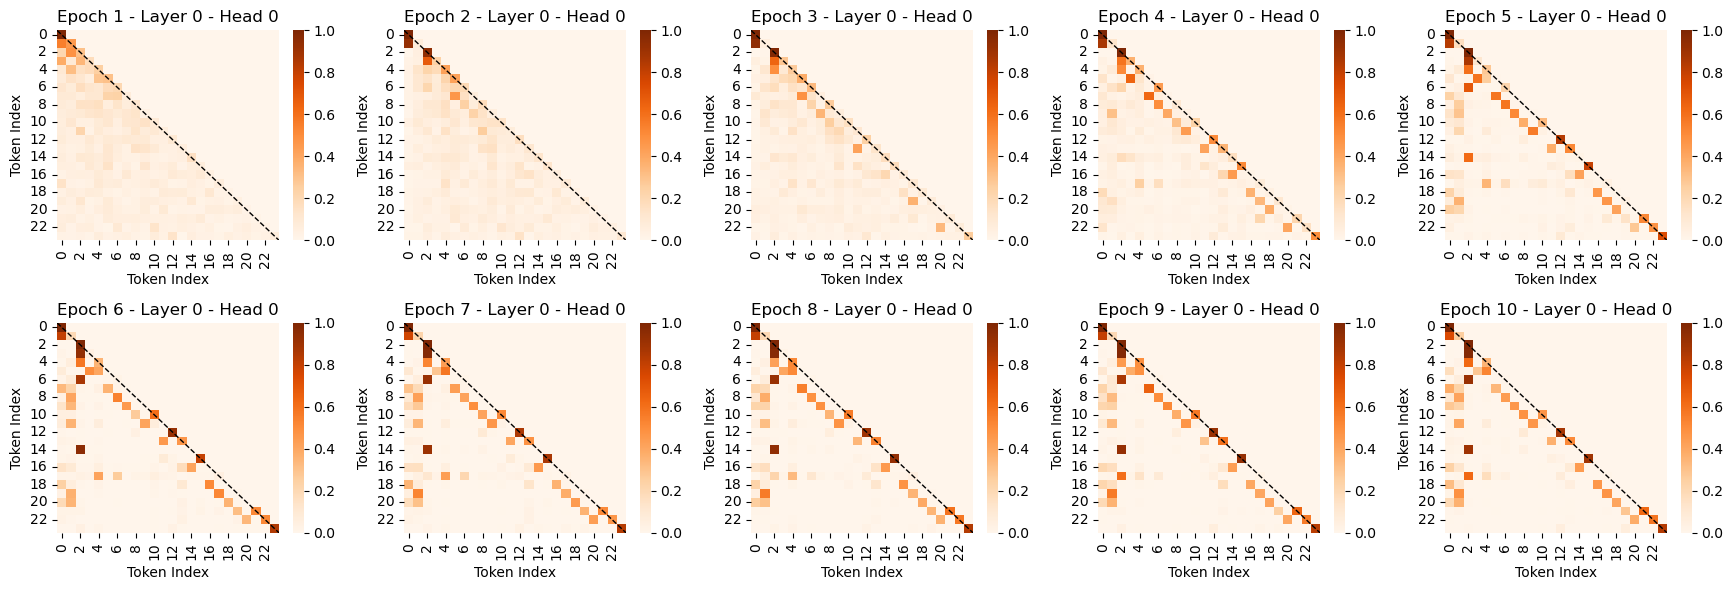

In [81]:
plot_attention_heatmaps_parallel(attention_weights, epoch_range=range(num_epochs), head_idx=0, layer_idx=0, cols=5)

# Entropy

In [82]:
entropies = []
accuracies = []
for i in range(3):
    N = i + 1
    N_entropy = []
    N_accuracy = []
    for m in range(num_models):
        print(f"Training model {m+1} for n = {i}")
        attention_weights, _, _, accuracy= Nback_train(N)
        entropy = np.sum(total_entropy(attention_weights), axis=1)
        N_accuracy.append(accuracy)
        N_entropy.append(entropy)
    
    entropies.append(np.array(N_entropy))
    accuracies.append(np.array(N_accuracy))


Training model 1 for n = 0
Epoch 1/10, Train Loss: 0.6287
Epoch 2/10, Train Loss: 0.5983
Epoch 3/10, Train Loss: 0.4798
Epoch 4/10, Train Loss: 0.3443
Epoch 5/10, Train Loss: 0.2764
Epoch 6/10, Train Loss: 0.2486
Epoch 7/10, Train Loss: 0.2375
Epoch 8/10, Train Loss: 0.2318
Epoch 9/10, Train Loss: 0.2318
Epoch 10/10, Train Loss: 0.2231
Input: wbbvksxxxfntwtgfnzzzzzss
Target: --m----mm---------mmmm-m
Predicted: --------mm----m---mmmm-m
Input: hcpfffddddnsyjhhrtxryyll
Target: ----mm-mmm-----m-----m-m
Predicted: -----m-mmm-----m-----m-m
Input: yrrrwfssvjkkylllwlbbbkby
Target: --mm---m---m--mm---mm---
Predicted: -------m---m---m----m---
Input: khhqnnnwttkhlgyygppjjjzs
Target: --m--mm--m-----m--m-mm--
Predicted: -----mm--m-----m--m-mm--
Input: ggttggrrrjtjjsfpxkssrjww
Target: -m-m-m-mm---m------m---m
Predicted: --------m---m-m--------m
Input: kknnzsszjxxxppkwwgzxnzdd
Target: -m-m--m---mm-m--m------m
Predicted: ------m---mm-m--m------m
Input: rxffnnrpvhhscghkssbbbbbq
Target: ---m-m----m-----

In [90]:
# save the entropies to npy file
np.save(f'entropies.npy', entropies)
# save the accuracies to npy file
np.save(f'accuracies.npy', accuracies)

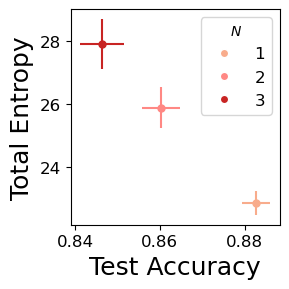

In [563]:
# print(entropies)
colormap = plt.get_cmap('Oranges', len(entropies))
# Plotting
plt.figure(figsize=(3, 3))

avg_accuracy = np.mean(accuracies, axis=1)
std_accuracy = np.std(accuracies, axis=1)
se_accuracy = std_accuracy / np.sqrt(num_models)


avg_entropy = np.mean(np.min(entropies, axis=2), axis=1)
std_entropy = np.std(np.min(entropies, axis=2), axis=1)
se_entropy = std_entropy / np.sqrt(num_models)

colors = ['#F8AC8C' ,'#FF8884', '#C82423']
for i in range(len(avg_accuracy)):  
    plt.errorbar(avg_accuracy[i], avg_entropy[i], yerr=se_entropy[i], xerr=se_accuracy[i], fmt='o', color=colors[i], label=f'{i+1}', markersize=5)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], label=i+1) for i in range(3)]

# Add the legend to the plot, only show the dot but not the line
plt.legend(handles=legend_elements, title='$N$',fontsize=12)


plt.xlabel('Test Accuracy',fontsize=18)
plt.ylabel('Total Entropy',fontsize=18)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.tight_layout()
# save the figure to pdf
plt.savefig(f'figures/accuracy_vs_entropy.pdf', format='pdf')
plt.show()